In [1]:
import pandas as pd
import numpy as np
from sympy import symbols, apart, inverse_laplace_transform, lambdify, Rational
from sympy.abc import s, t
from scipy import signal
from pandasgui import show
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import symbols, Heaviside, exp, lambdify, sympify, exp
import matplotlib.ticker as mticker
from decimal import Decimal, getcontext

### definição do contexto:

In [2]:
# Parâmetros de tempo e amostragem
tempo = 30
amostragem = 0.01
numeropontos = int(tempo / amostragem)
t_step = 0

# Parâmetros do modelo
CA0rp = 0.925
Frp = 0.085
CArp = 0.236
k = 0.5
V = 2.1

# Parâmetros das funções de transferência
tau = V / (Frp + k * V * 2 * CArp)
K1 = Frp / (Frp + 2 * k * V * CArp)
K2 = (CA0rp - CArp) / (Frp + k * V * 2 * CArp)

# Funções de transferência
numerator_G1 = [K1] # G1 = K1 / (tau * s + 1)
denominator_G1 = [tau, 1]
numerator_G2 = [K2] # G2 = K2 / (tau * s + 1)
denominator_G2 = [tau, 1]

G1 = signal.TransferFunction(numerator_G1, denominator_G1) # função para a concentração
G2 = signal.TransferFunction(numerator_G2, denominator_G2) # função para a vazão volumétrica

# Análise da resposta - Polinômio da função de transferência de primeira ordem
delta_1a_ordem = [tau, 1]
tau_1ordem = tau
raizes = np.roots(delta_1a_ordem)
# Criando o vetor de tempo de 0 a 30 com incremento de 0.01
vetor_tempo = np.arange(0, tempo, amostragem)

# Valores para degrau no sistema
MCA0 = 0.1
MF = 0.05

# Exibindo os resultados
print("Parâmetro tau:", tau)
print("Parâmetro K1:", K1)
print("Parâmetro K2:", K2)
print("Raízes do polinômio de primeira ordem:", raizes)
print("Teorema do valor final:", K1*MCA0+K2*MF+CArp)
# print("Função de transferência G1(s):", G1)
# print("Função de transferência G2(s):", G2)


Parâmetro tau: 3.6169479848432657
Parâmetro K1: 0.14640027557698934
Parâmetro K2: 1.186703410265243
Raízes do polinômio de primeira ordem: [-0.27647619]
Teorema do valor final: 0.3099751980709611


### tranformada de laplace inversa e resultados:

In [3]:
def inversa_laplace(funcoes, tempo):
    resultados_individuais = []
    funcao_vetor = 0
    resultado_final = np.zeros(len(tempo))  # Inicializa um vetor para a soma total
    funcao_inversa_final = 0  # Para somar as funções inversas de todas as funções de transferência
    for i, (num, den, regime_permanente, disturbio) in enumerate(funcoes):
        # Converte o numerador e denominador em uma expressão simbólica de Laplace
        H_s = sum([num[j] * s**(len(num) - j - 1) for j in range(len(num))]) / sum([den[j] * s**(len(den) - j - 1) for j in range(len(den))])
        # Adiciona a função de distúrbio M/s, se fornecida
        H_s *= Rational(disturbio, 1) / s
        # Expande H_s em frações parciais, se aplicável
        H_s_expanded = apart(H_s, s)
        print(f"Frações parciais para função {i+1}:", H_s_expanded)
        # Calcula a transformada inversa de Laplace
        h_t = inverse_laplace_transform(H_s_expanded, s, t)
        print(f"Transformada inversa de Laplace para função {i+1}:", h_t, "\n")
        # Adiciona a função inversa atual à função inversa final
        funcao_inversa_final += h_t
        # Converte a função simbólica em uma função numérica de t usando lambdify
        h_t_func = lambdify(t, h_t, modules="numpy")
        # Avalia a função para cada valor no vetor de tempo
        resultado_tempo = h_t_func(tempo)
        # Aplica o regime permanente e o distúrbio após M_tempo
        resultado_com_rp = resultado_tempo + regime_permanente
        # resultado_com_rp = np.where(tempo >= M_tempo, resultado_tempo + disturbio + regime_permanente, resultado_tempo + regime_permanente)
        # Armazena os resultados individuais e com regime permanente
        resultados_individuais.append({
            f"Resultado_Funcao_{i+1}": resultado_tempo,
            f"Resultado_com_RP_Funcao_{i+1}": resultado_com_rp
        })
        # Adiciona o resultado com RP ao resultado final apenas se o distúrbio for diferente de zero
        if disturbio != 0:
            resultado_final += resultado_com_rp
        else:
            # Caso o distúrbio seja zero, adiciona apenas a parte dinâmica (sem regime permanente)
            resultado_final += resultado_tempo
        funcao_vetor += h_t
    # Constrói o DataFrame com todas as colunas
    df = pd.DataFrame({"Tempo": tempo})
    # Adiciona cada conjunto de resultados individuais ao DataFrame
    for resultado in resultados_individuais:
        for coluna, valores in resultado.items():
            df[coluna] = valores
    # Adiciona a coluna de resultado final (soma de todas as funções)
    df["Resultado_Final"] = resultado_final
    # Adiciona a expressão da função inversa final ao DataFrame
    df["Funcao_Inversa_Final"] = [str(funcao_inversa_final)] * len(tempo)
    return df, funcao_vetor


# Exemplo de uso com múltiplas funções de transferência e seus respectivos parâmetros
funcoes = [(numerator_G1, denominator_G1, CArp, MCA0), (numerator_G2, denominator_G2, Frp, MF)]
# Criando um vetor de tempo de 0 a 30 com incremento de 0.01
vetor_tempo = np.arange(0, 30, 0.01)
# Calculando a resposta no tempo com regime permanente e distúrbio para cada função
resultado, funcao = inversa_laplace(funcoes, vetor_tempo)
# Exportando o DataFrame para um arquivo Excel em um caminho escolhido
caminho_arquivo = r"C:\Users\orlan\Downloads\ACP (ORLANDO - 2024)\PYTHON\ps\resultado_G1.xlsx"
resultado.to_excel(caminho_arquivo, index=False)
print("Arquivo Excel salvo em:", caminho_arquivo)

Frações parciais para função 1: -0.0146400275576989/(1.0*s + 0.27647619047619) + 0.0146400275576989/s
Transformada inversa de Laplace para função 1: 0.0146400275576989*Heaviside(t) - 0.0146400275576989*exp(-0.27647619047619*t)*Heaviside(t) 

Frações parciais para função 2: -0.0593351705132621/(1.0*s + 0.27647619047619) + 0.0593351705132621/s
Transformada inversa de Laplace para função 2: 0.0593351705132621*Heaviside(t) - 0.0593351705132621*exp(-0.27647619047619*t)*Heaviside(t) 

Arquivo Excel salvo em: C:\Users\orlan\Downloads\ACP (ORLANDO - 2024)\PYTHON\ps\resultado_G1.xlsx


a função a ser implementada é: 0.073975198070961*Heaviside(t) - 0.073975198070961*exp(-0.27647619047619*t)*Heaviside(t)
Função Simbólica: 0.073975198070961 - 0.073975198070961*exp(-0.27647619047619*t)


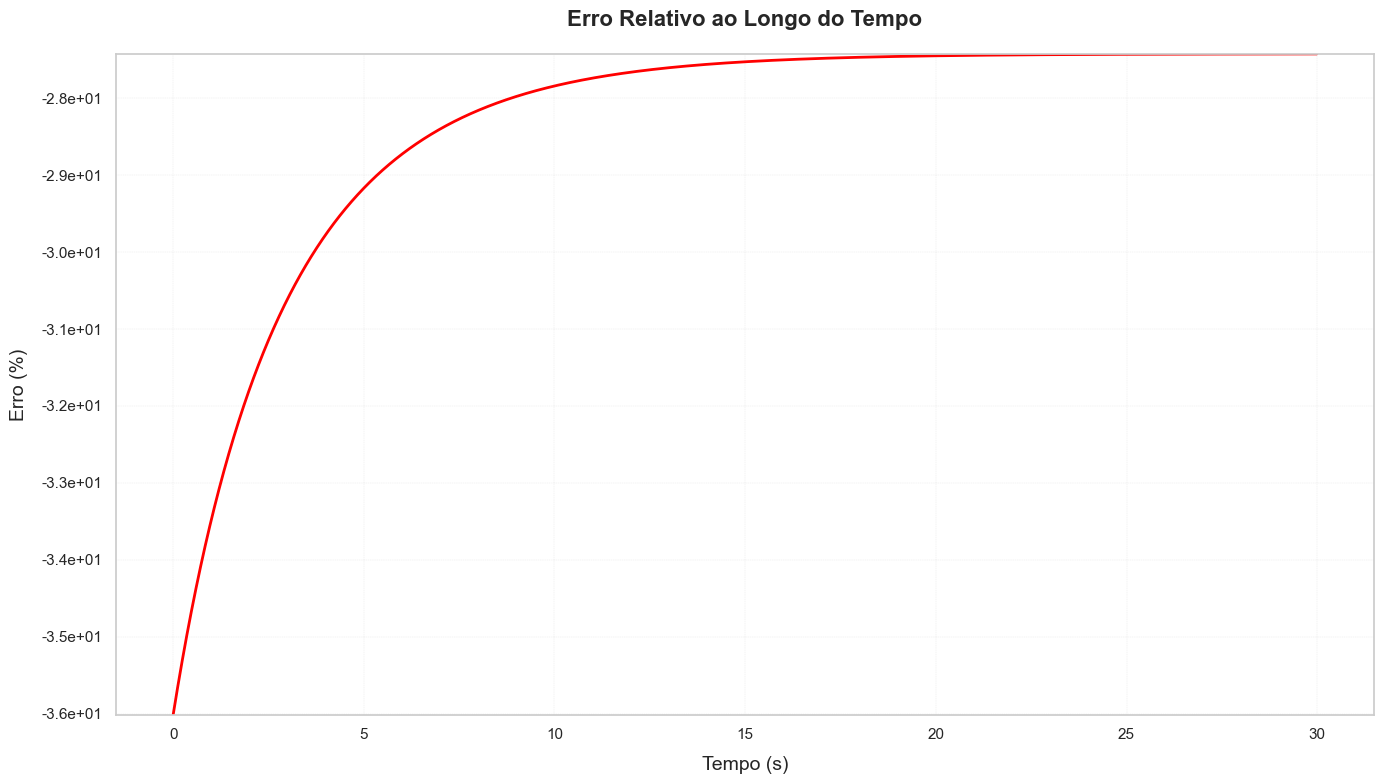

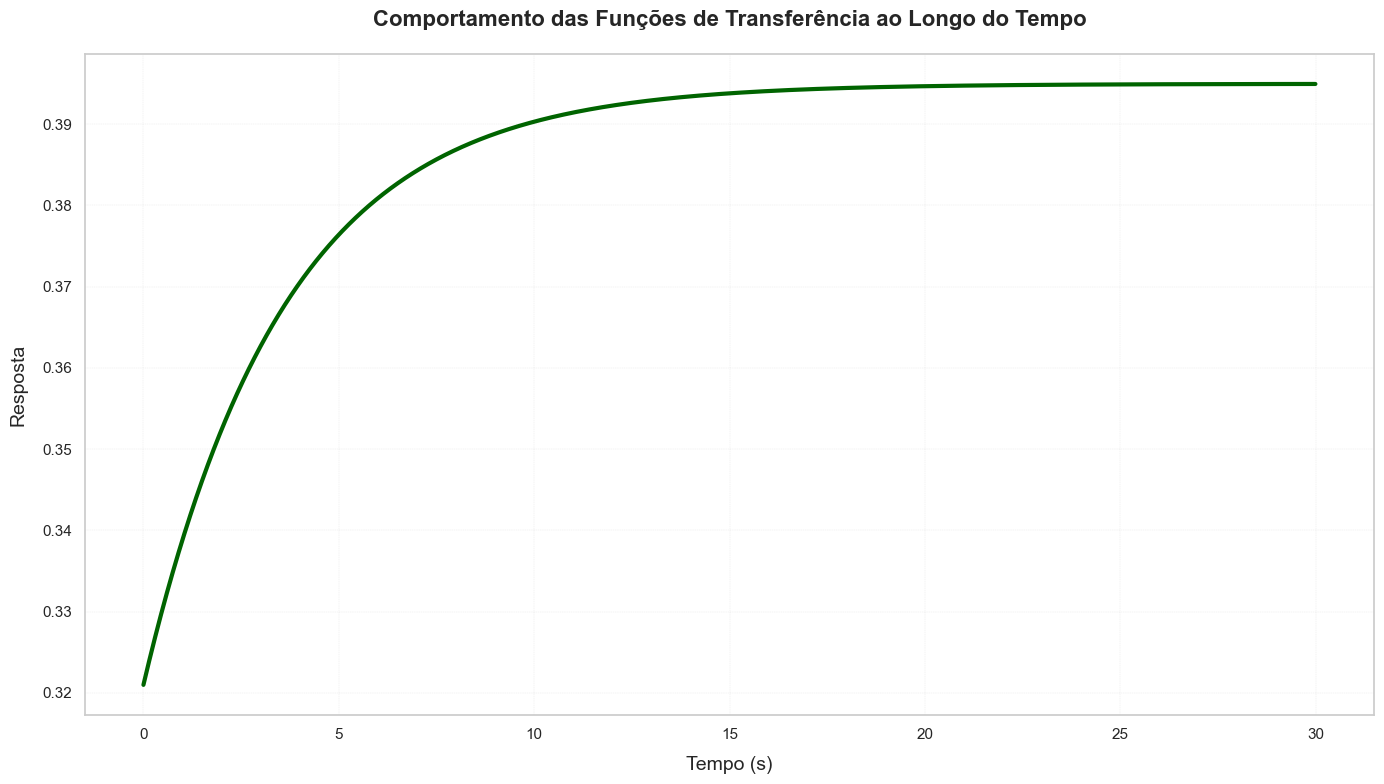

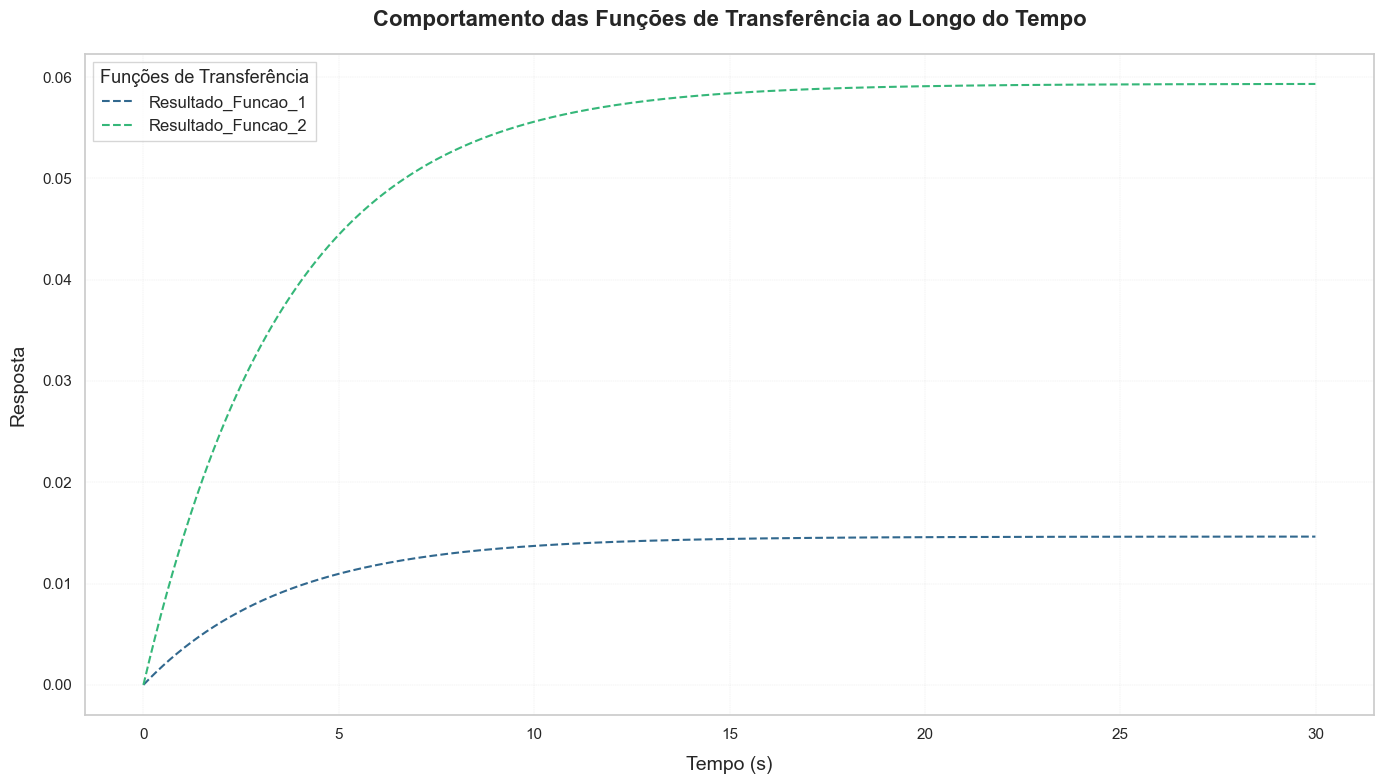

In [4]:
def grafico_no_tempo(df_resultado):
    # Configura o estilo do Seaborn e define uma cor verde escura para o gráfico
    sns.set(style="whitegrid")
    cor_verde_escuro = "#006400"  # Cor verde escuro em hexadecimal
    # Geração dos gráficos com ajustes visuais
    plt.figure(figsize=(14, 8))
    # Gráfico do Resultado Final em destaque
    plt.plot(df_resultado["Tempo"], df_resultado["Resultado_Final"], label="Resultado_Final", color=cor_verde_escuro, linewidth=3, linestyle="-")
    # Ajustes do gráfico com legendas e estética melhorada
    plt.xlabel("Tempo (s)", fontsize=14, labelpad=10)
    plt.ylabel("Resposta", fontsize=14, labelpad=10)
    plt.title("Comportamento das Funções de Transferência ao Longo do Tempo", fontsize=16, weight='bold', pad=20)
    # Configurações da grade: quase invisível e tracejada
    plt.grid(color="gray", linestyle="--", linewidth=0.3, alpha=0.2)
    # Exibição do gráfico com layout ajustado
    plt.tight_layout()
    plt.show()


def grafico_das_funcoes(df_resultado):
    # Configura o estilo do Seaborn e define a cor preta para o Resultado_Final
    sns.set(style="whitegrid")
    # Geração dos gráficos com ajustes visuais
    plt.figure(figsize=(14, 8))
    # Configura uma paleta de cores para as funções individuais
    cores = sns.color_palette("viridis", len([col for col in df_resultado.columns if "Resultado_Funcao" in col]))
    # Gráfico da função no tempo para cada função de transferência com cores diferentes
    for i, coluna in enumerate([col for col in df_resultado.columns if "Resultado_Funcao" in col]):
        plt.plot(df_resultado["Tempo"], df_resultado[coluna], label=coluna, color=cores[i], linestyle="--", linewidth=1.5)
    # Ajustes do gráfico com legendas e estética melhorada
    plt.xlabel("Tempo (s)", fontsize=14, labelpad=10)
    plt.ylabel("Resposta", fontsize=14, labelpad=10)
    plt.title("Comportamento das Funções de Transferência ao Longo do Tempo", fontsize=16, weight='bold', pad=20)
    # Estilo da legenda
    plt.legend(title="Funções de Transferência", fontsize=12, title_fontsize='13', loc="best", frameon=True, shadow=False, fancybox=False)
    # Configurações da grade: quase invisível e tracejada
    plt.grid(color="gray", linestyle="--", linewidth=0.3, alpha=0.2)
    # Exibição do gráfico com layout ajustado
    plt.tight_layout()
    plt.show()


def calcular_erro_e_plotar(df_resultado, funcao_algebrica, tempo, RP):
    # Configura a precisão para 16 casas decimais
    getcontext().prec = 16
    # Define o símbolo 't' para a expressão simbólica
    t = symbols('t')
    # Converte a função algebrica para uma expressão simbólica e garante que Heaviside(t) seja tratado como 1
    funcao_simb = sympify(funcao_algebrica.replace("Heaviside(t)", "1"))
    print("Função Simbólica:", funcao_simb)
    # Converte a função simbólica em uma função numérica
    funcao_numerica = lambdify(t, funcao_simb, modules="numpy")
    # Avalia 'valor_algebrico' para cada valor no vetor de tempo e adiciona o regime permanente (RP) com precisão Decimal
    valor_algebrico = [Decimal(funcao_numerica(float(t_val))) + Decimal(RP) for t_val in tempo]
    # Converte 'Resultado_Final' para Decimal e calcula o ERRO com precisão
    resultado_final = [Decimal(val) for val in df_resultado["Resultado_Final"].values]
    ERRO = [(Decimal(0) if va == 0 else ((va - rf) / va) * 100) for va, rf in zip(valor_algebrico, resultado_final)]
    # Cria um novo DataFrame com todas as informações e com precisão de 16 casas decimais
    df_erro = pd.DataFrame({"Tempo": tempo, "Valor_Algebrico": valor_algebrico, "Resultado_Final": resultado_final, "ERRO": ERRO})
    # Plotando o erro em função do tempo
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")
    plt.plot(df_erro["Tempo"], df_erro["ERRO"], color="red", linewidth=2)
    # Configurações do gráfico
    plt.xlabel("Tempo (s)", fontsize=14, labelpad=10)
    plt.ylabel("Erro (%)", fontsize=14, labelpad=10)
    plt.title("Erro Relativo ao Longo do Tempo", fontsize=16, weight='bold', pad=20)
    plt.grid(color="gray", linestyle="--", linewidth=0.3, alpha=0.2)
    # Configura o eixo y para notação científica com precisão de 16 casas decimais
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))
    plt.tight_layout()
    plt.ylim(min(ERRO), max(ERRO))  # Define os limites do eixo y de 0 a 60
    plt.show()
    return df_erro



print("a função a ser implementada é:", funcao)
funcao = str(funcao)
calcular_erro_e_plotar(resultado, funcao, vetor_tempo, Decimal(CArp))
grafico_no_tempo(resultado)
grafico_das_funcoes(resultado)